<a href="https://colab.research.google.com/github/yiftachsa/AI-Advanced/blob/main/Donations_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Yarden Bibas crowd funding donations analysis
A quick exploration of donations made to the crowd funding campaign for  Yarden Bibas. This analysis includes **collecting the data** by scraping the crowd-funding platform. The data is then preprocessed (standardizing time format and currency). This is followed by v**isualizations of the donations amounts over time and the amounts distribution.**

**Sentiment analysis** is used to score each English comment using **nltk's SentimentIntensityAnalyzer and DistilBert**. This is done to extract the sentiments of the comments and to evaluate briefly **whether there is a correlation between the sentiment and the donation's amount**. In other words, *whether people who comment positively donated more then people who commented negatively (from a place of pain, asking for forgiveness, etc.).*

Lastly, examinations of the **most frequent words** is done to get a quick high level insight of the overall sentiments (using tokenization and lemmatization). The **word frequencies** are used to build **words clouds**.  

#Init

In [ ]:
# Install required libraries
!pip install selenium beautifulsoup4 pandas matplotlib

In [ ]:
# Import libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from datetime import datetime, timedelta
import re
import plotly.graph_objects as go

#Data

##Scraping (Collecting data)

In [ ]:
# Selenium WebDriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')  # browser in headless mode
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(options=options)

# donation site
url = "https://yad.reachhands.com/bibasusliire"
driver.get(url)

# Automate 'Load More' button clicks
count = 0
max_calls = float('inf')

while count < max_calls:
    try:
        # Locate 'Load More' button
        load_more_button = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, "loadMore"))
        )
        # button visible (if hidden)
        driver.execute_script("arguments[0].classList.remove('hide');", load_more_button)
        driver.execute_script("arguments[0].style.display = 'block';", load_more_button)

        # using JavaScript
        driver.execute_script("arguments[0].click();", load_more_button)

        # Wait for loader to appear
        WebDriverWait(driver, 10).until(
            EC.visibility_of_element_located((By.ID, "tbLoader"))
        )
        WebDriverWait(driver, 10).until(
            EC.invisibility_of_element((By.ID, "tbLoader"))
        )
        if count % 100 == 0:
            print(f"Count: {count}")
        count += 1

    except Exception as e:
        print("No more 'Load More' button or additional content available.")
        break

soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()
# pprint(soup.prettify())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 31.7 MB/s eta 0:00:00
Count: 0
Count: 10
Count: 20
Count: 30
Count: 40
Count: 50
Count: 60
Count: 70
Count: 80
Count: 90
Count: 100
Count: 110
Count: 120
Count: 130
Count: 140
Count: 150
Count: 160
Count: 170
Count: 180
Count: 190
Count: 200
Count: 210
Count: 220
Count: 230
Count: 240
Count: 250
Count: 260
Count: 270
Count: 280
Count: 290
Count: 300
Count: 310
Count: 320
Count: 330
Count: 340
Count: 350
Count: 360
Count: 370
Count: 380
Count: 390
Count: 400
Count: 410
Count: 420
Count: 430
Count: 440
Count: 450
Count: 460
Count: 470
Count: 480
Count: 490
Count: 500
Count: 510
Count: 520
Count: 530
Count: 540
Count: 550
Count: 560
Count: 570
Count: 580
Count: 590
Count: 600
Count: 610
Count: 620
Count: 630
Count: 640
Count: 650
Count: 660
Count: 670
Count: 680
Count: 690
Count: 700
Count: 710
Count: 720
Count: 730
Count: 740
Count: 750
Count: 760
Count:

##Preprocess

In [ ]:
def convert_relative_time(relative_time):
    current_time = datetime.now()

    # special case: "a minute ago"
    if relative_time == "a minute ago":
        return (current_time - timedelta(minutes=1)).strftime("%d-%m-%Y %H:%M")

    # regex to parse complex time strings like "16 hours and 38 minutes ago"
    time_pattern = re.compile(r'(\d+)\s*(minute|hour|day|week)')
    matches = time_pattern.findall(relative_time)

    delta = timedelta()
    for value, unit in matches:
        value = int(value)
        if "minute" in unit:
            delta += timedelta(minutes=value)
        elif "hour" in unit:
            delta += timedelta(hours=value)
        elif "day" in unit:
            delta += timedelta(days=value)
        elif "week" in unit:
            delta += timedelta(weeks=value)

    # Subtract the total delta from the current time
    converted_time = current_time - delta
    return converted_time.strftime("%d-%m-%Y %H:%M")

# Examples
print(convert_relative_time("16 hours and 38 minutes ago"))  # Test with complex time
print(convert_relative_time("2 days and 5 hours ago"))        # Another example
print(convert_relative_time("a minute ago"))                 # Special case
print(convert_relative_time("12 minutes ago"))

16-03-2025 22:59
15-03-2025 10:37
17-03-2025 15:36
17-03-2025 15:25


In [ ]:
# Extract donation data
donations = []
for entry in soup.select("tr"):  # Iterate over table row
    try:
        # Parse donor name
        name = entry.select_one("td.info span.name").text.strip()
    except AttributeError:
        name = "Anonymous"

    try:
        # Parse comment
        comment = entry.select_one("td.info span.comment").text.strip()
    except AttributeError:
        comment = "No comment"

    try:
        # Parse donation amount
        amount = entry.select_one("td.details span.amount").text.strip()
    except AttributeError:
        amount = "0"

    try:
        # Parse donation time
        time = entry.select_one("td.details span.amount-time").text.strip()
    except AttributeError:
        time = "Unknown Time"

    donations.append({"Name": name, "Amount": amount, "Time": time, "Comment": comment})

df = pd.DataFrame(donations)
df['Time'] = df['Time'].replace('less than a minute ago', 'a minute ago', regex=True)
df['Time'] = df['Time'].apply(lambda x: convert_relative_time(x) if x != "Unknown Time" else x)  # Convert time to datetime
# df['Amount'] = df['Amount'].replace('[^\d.]', '', regex=True).astype(float)  # Strip non-numeric characters and convert to float

print(df)


                   Name Amount              Time  \
0               A Moses   $230  17-03-2025 15:36   
1          Loulou WEISS    $50  17-03-2025 15:32   
2          Pascal Reber   $180  17-03-2025 15:31   
3         Alex Sandhaus    $54  17-03-2025 15:30   
4      Hannah Kleinfeld    £25  17-03-2025 15:28   
...                 ...    ...               ...   
31090         Anonymous   ₪200  17-03-2025 15:37   
31091         רוני פורת    ₪50  17-03-2025 15:37   
31092         Anonymous    ₪18  17-03-2025 15:37   
31093       קטיה אגינוב    ₪50  17-03-2025 15:37   
31094        Tami Raich   ₪200  17-03-2025 15:37   

                                             Comment  
0                                         No comment  
1                                         No comment  
2                                         No comment  
3      May you find the strength to keep fighting 🙌🏻  
4                                         No comment  
...                                          

In [ ]:
# Conversion rates
conversion_rates = {
    '€': 4.2,  # Euro to NIS
    '$': 3.7,  # USD to NIS
    '£': 4.8,  # GBP to NIS
    '₪': 1.0   # NIS to NIS (no conversion needed)
}

# convert to NIS
def convert_to_nis(amount_str):
    # Remove commas and currency symbols
    for symbol in conversion_rates.keys():
        if symbol in amount_str:
            amount_str = amount_str.replace(symbol, '').replace(',', '')
            amount_value = float(amount_str)
            return amount_value * conversion_rates[symbol]
    return 0  # in case the currency is not recognized

df['Amount_in_NIS'] = df['Amount'].apply(convert_to_nis)

print(df)


                   Name Amount              Time  \
0               A Moses   $230  17-03-2025 15:36   
1          Loulou WEISS    $50  17-03-2025 15:32   
2          Pascal Reber   $180  17-03-2025 15:31   
3         Alex Sandhaus    $54  17-03-2025 15:30   
4      Hannah Kleinfeld    £25  17-03-2025 15:28   
...                 ...    ...               ...   
31090         Anonymous   ₪200  17-03-2025 15:37   
31091         רוני פורת    ₪50  17-03-2025 15:37   
31092         Anonymous    ₪18  17-03-2025 15:37   
31093       קטיה אגינוב    ₪50  17-03-2025 15:37   
31094        Tami Raich   ₪200  17-03-2025 15:37   

                                             Comment  Amount_in_NIS  
0                                         No comment          851.0  
1                                         No comment          185.0  
2                                         No comment          666.0  
3      May you find the strength to keep fighting 🙌🏻          199.8  
4                        

In [ ]:
# Convert to datetime
df['datetime'] = pd.to_datetime(df['Time'], format="%d-%m-%Y %H:%M")

df['hour'] = df['datetime'].dt.floor('H')  # Group by the hour

df = df.sort_values(by='Time')

df['Cumulative Total'] = df['Amount_in_NIS'].cumsum()

<ipython-input-6-836b6c8e2ffc>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['datetime'].dt.floor('H')  # Group by the hour


##Visualization

###Donations over time

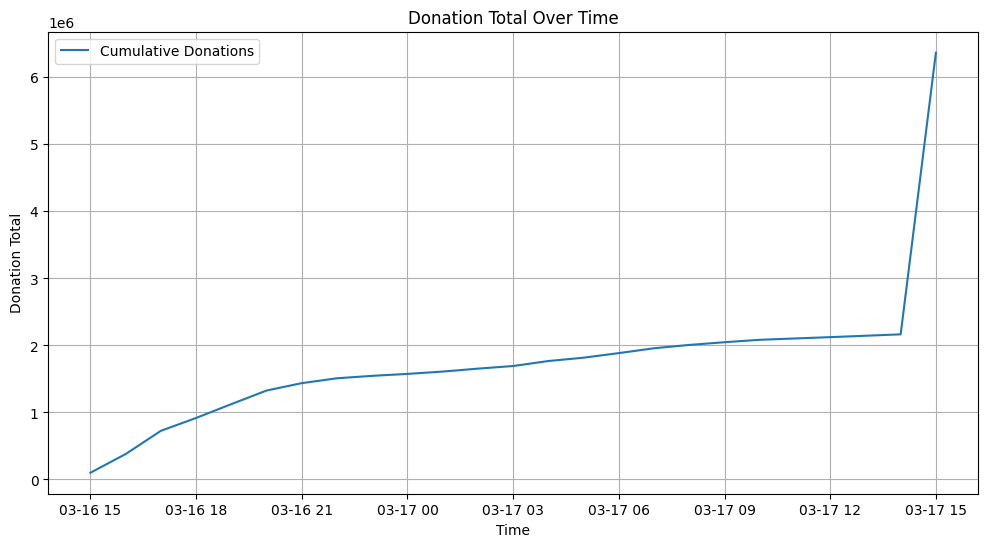

In [ ]:
df_last_in_hour = df.groupby('hour').last().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_last_in_hour['hour'], df_last_in_hour['Cumulative Total'], label="Cumulative Donations")
plt.xlabel("Time")
plt.ylabel("Donation Total")
plt.title("Donation Total Over Time")
plt.legend()
plt.grid(True)
plt.show()


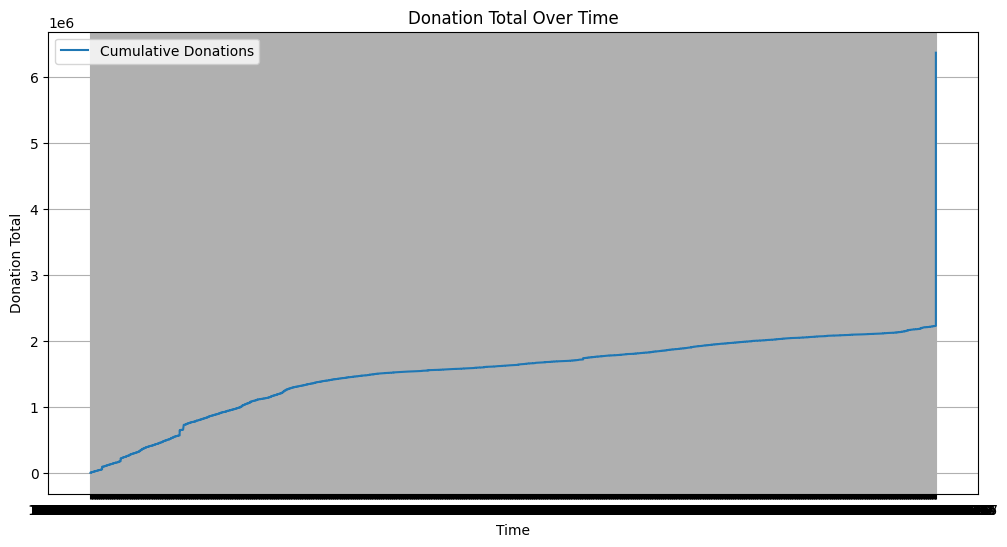

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Cumulative Total'], label="Cumulative Donations")
plt.xlabel("Time")
plt.ylabel("Donation Total")
plt.title("Donation Total Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import plotly.express as px

# Plot cumulative sum
fig = px.line(df[::10], x='Time', y='Cumulative Total', title='Cumulative Sum over Time', labels={'Cumulative Total': 'Cumulative Amount'}, hover_data={'Amount_in_NIS': True})
fig.show()


In [ ]:
# 99th percentile
top_1_quantile_thresh = np.quantile(df['Amount_in_NIS'], 0.99)
top_1_quantile = df[df['Amount_in_NIS'] > top_1_quantile_thresh]

top_0_1_quantile_thresh = np.quantile(df['Amount_in_NIS'], 0.999)
top_0_1_quantile = df[df['Amount_in_NIS'] > top_0_1_quantile_thresh]

fig = px.line(df,
              x='Time',
              y='Cumulative Total',
              title='Cumulative Sum over Time',
              labels={'Cumulative Total': 'Cumulative Amount'},
              hover_data={'Amount_in_NIS': True})

# Add scatter plot for 99th percentile outliers in orange
fig.add_trace(go.Scatter(
    x=top_1_quantile['Time'],
    y=top_1_quantile['Cumulative Total'],
    mode='markers',
    marker=dict(color='orange', size=8),
    name='top_1_quantile',
    text=top_1_quantile['Amount_in_NIS'].apply(lambda x: str(x) + " NIS"),  # Text for hover display
    # hoverinfo='text'  # Show only text in hover tooltip
))

# Add scatter plot for 99.9th percentile outliers in red
fig.add_trace(go.Scatter(
    x=top_0_1_quantile['Time'],
    y=top_0_1_quantile['Cumulative Total'],
    mode='markers',
    marker=dict(color='red', size=8),
    name='top_0.1_quantile',
    text=top_0_1_quantile['Amount_in_NIS'].apply(lambda x: str(x) + " NIS"),  # Text for hover display
    # hoverinfo='text'  # Show only text in hover tooltip
))

# Show the plot
fig.show()

###Donations Distribution - Histogram of Amount with Density Estimation

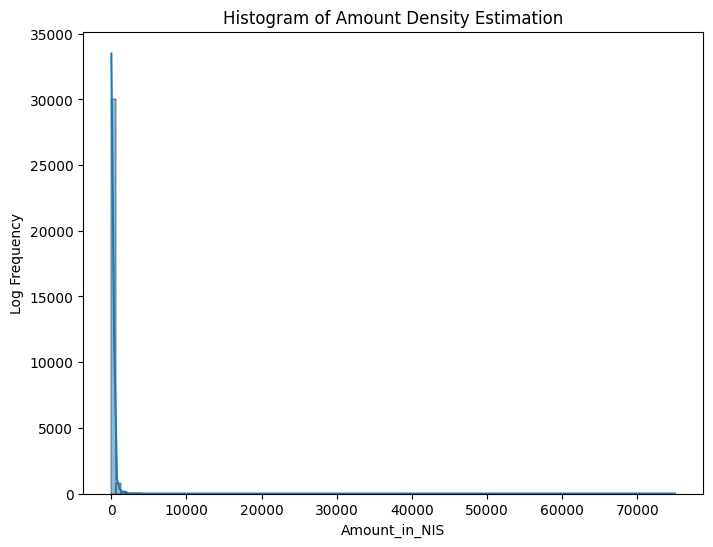

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(df['Amount_in_NIS'], kde=True, bins=120)
plt.title('Histogram of Amount Density Estimation')
plt.xlabel('Amount_in_NIS')
plt.ylabel('Log Frequency')
plt.show()

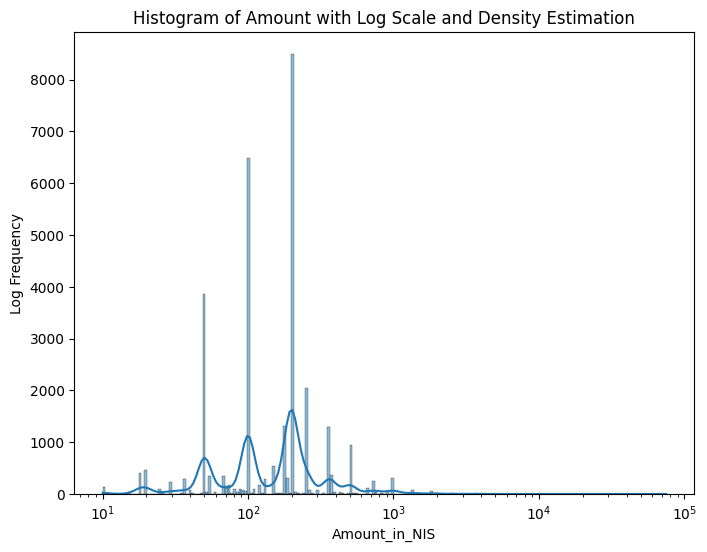

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Amount_in_NIS'], log_scale=True, kde=True)
plt.title('Histogram of Amount with Log Scale and Density Estimation')
plt.xlabel('Amount_in_NIS')
plt.ylabel('Log Frequency')
plt.show()

###Top 0.1% Donations

In [ ]:
top_0_1_quantile.sort_values(by='Amount_in_NIS', ascending=False)

Name   Amount              Time  \
8916                       Anonymous  ₪75,000  16-03-2025 17:50   
1222                    Luiz Meisler  $20,000  16-03-2025 17:56   
1472                 Anna Pratolongo  $10,000  16-03-2025 15:55   
1425                 Alexander Gerko  $10,000  16-03-2025 16:22   
348                  Jina Davidovich   $5,400  17-03-2025 04:30   
1857                Danielle Mizrahi   $5,000  17-03-2025 15:37   
1828     Sophie and Dorian Kornowski   $5,000  17-03-2025 15:37   
2650                       Cpossible   $4,000  17-03-2025 15:37   
19014  אלידן קידוחים ופרוייקטים בע"מ  ₪10,000  17-03-2025 15:37   
13249                      Anonymous  ₪10,000  17-03-2025 15:37   
21729                  חני גולדשטיין  ₪10,000  17-03-2025 15:37   
16679                      Anonymous  ₪10,000  17-03-2025 15:37   
115                    Suzanne Fulop   $2,000  17-03-2025 15:15   
1015                       Anonymous   $1,800  16-03-2025 20:10   
2318                   CeliA safdieh   $1,566  17-03-2025 15:37   
1896                       Anonymous   $1,500  17-03-2025 15:37   
29408                      Anonymous   ₪5,000  17-03-2025 15:37   
14358                      Anonymous   ₪5,000  17-03-2025 15:37   
7244                  ofra rozenblat   ₪5,000  16-03-2025 19:40   
17298            פאראזר אדוורטייזינג   ₪5,000  17-03-2025 15:37   
11563          ניר יוגב יזמויות בע"מ   ₪4,000  17-03-2025 15:37   

                                                 Comment  Amount_in_NIS  \
8916                                          No comment        75000.0   
1222                                          No comment        74000.0   
1472                                          No comment        37000.0   
1425                                          No comment        37000.0   
348                                           No comment        19980.0   
1857                                          No comment        18500.0   
1828   Dear Yarden, Dorian and Sophie are with you! O...        18500.0   
2650      Candle for Israel  stand with the Bibas family        14800.0   
19014                      ג'ומי אוהבים אותך משפחת דמרי🧡        10000.0   
13249                                    תודה על מי שאתה        10000.0   
21729  ירדן, אנחנו לא מכירים אבל חדרת לנו ללב כל כך, ...        10000.0   
16679                                         No comment        10000.0   
115    Yarden, sending so much love from Bethesda, Ma...         7400.0   
1015   May Shiri, Ariel and Kfir's memory bless Yarde...         6660.0   
2318                                          No comment         5794.2   
1896                           Always in our thoughts...         5550.0   
29408                                         No comment         5000.0   
14358                                         No comment         5000.0   
7244   אוהבים ועצובים ומקוים לטוב , שכונת תל ברוך הדר...         5000.0   
17298                                         No comment         5000.0   
11563  ירדן היקר\n\nיש לנו הזכות לתרום לך לחיים טובים...         4000.0   

                 datetime                hour  Cumulative Total  
8916  2025-03-16 17:50:00 2025-03-16 17:00:00          640653.4  
1222  2025-03-16 17:56:00 2025-03-16 17:00:00          725812.6  
1472  2025-03-16 15:55:00 2025-03-16 15:00:00           89473.1  
1425  2025-03-16 16:22:00 2025-03-16 16:00:00          215411.9  
348   2025-03-17 04:30:00 2025-03-17 04:00:00         1737369.7  
1857  2025-03-17 15:37:00 2025-03-17 15:00:00         5080966.1  
1828  2025-03-17 15:37:00 2025-03-17 15:00:00         5058189.7  
2650  2025-03-17 15:37:00 2025-03-17 15:00:00         4819519.2  
19014 2025-03-17 15:37:00 2025-03-17 15:00:00         5791027.2  
13249 2025-03-17 15:37:00 2025-03-17 15:00:00         4153817.7  
21729 2025-03-17 15:37:00 2025-03-17 15:00:00         3085596.7  
16679 2025-03-17 15:37:00 2025-03-17 15:00:00         6347471.2  
115   2025-03-17 15:15:00 2025-03-17 15:00:00   

In [ ]:
df['Amount_in_NIS'].describe()

count    31095.000000
mean       204.766786
std        742.443034
min         10.000000
25%        100.000000
50%        180.000000
75%        200.000000
max      75000.000000
Name: Amount_in_NIS, dtype: float64

#Sentiment analysis using nltk and Bert (transformer - based)

In [ ]:
!pip install langdetect
# !pip install transformers
# !pip install torch

In [ ]:
import langdetect
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon (needed for sentiment analysis)
nltk.download('vader_lexicon')

# Function to detect English comments
def is_language(text, language='en'):
    try:
        return langdetect.detect(text) == language
    except:
        return False  # Handle potential detection errors


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
df.to_csv('df.csv')

In [ ]:
# only English comments
df_with_comment = df[df['Comment'] != 'No comment']

is_english = df_with_comment['Comment'].apply(is_language)
is_hebrew = df_with_comment['Comment'].apply(is_language, language='he')

df_en = df_with_comment[is_english].reset_index(drop=True)
df_he = df_with_comment[is_hebrew].reset_index(drop=True)
df_other = df_with_comment[~is_english & ~is_hebrew].reset_index(drop=True)


In [ ]:
print(df_with_comment.shape, df_en.shape, df_he.shape, df_other.shape)
print(len(df_en) + len(df_he) + len(df_other))

(6239, 8) (1034, 8) (4724, 8) (481, 8)
6239


In [ ]:
class SentimentNLTKModel:
    def __init__(self):
        self.model = SentimentIntensityAnalyzer()

    def get_sentiment_score(self, text):
        score = self.model.polarity_scores(text)['compound']
        return score

    def get_sentiment_txt(self, text):
        score = self.get_sentiment_score(text)
        return self.__sentiment_score_to_txt(score)

    def __sentiment_score_to_txt(self, score):
        sentiment = ""
        if score >= 0.5:
            sentiment = "Very Positive"
        elif score >= 0.1:
            sentiment = "Positive"
        elif score > -0.1:
            sentiment = "Neutral"
        elif score > -0.5:
            sentiment = "Negative"
        else:
            sentiment = "Very Negative"
        return sentiment

    def get_categories(self):
        return ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

sia_nltk = SentimentNLTKModel()
df_en['Sentiment_score_nltk'] = df_en['Comment'].apply(lambda x: sia_nltk.get_sentiment_score(x))
df_en['Sentiment_nltk'] = df_en['Comment'].apply(lambda x: sia_nltk.get_sentiment_txt(x))
df_en['Sentiment_nltk'] = pd.Categorical(df_en['Sentiment_nltk'], categories=sia_nltk.get_categories(), ordered=True)


Transformer

In [ ]:
!pip uninstall transformers sympy -y
!pip install --upgrade transformers sympy
!pip install torch datasets


Found existing installation: transformers 4.49.0
Uninstalling transformers-4.49.0:
  Successfully uninstalled transformers-4.49.0
Found existing installation: sympy 1.13.1
Uninstalling sympy-1.13.1:
  Successfully uninstalled sympy-1.13.1
  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
Using cached transformers-4.49.0-py3-none-any.whl (10.0 MB)
Using cached sympy-1.13.3-py3-none-any.whl (6.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.


  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3


In [1]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch

# from tqdm import tqdm
# tqdm.pandas()

# class SentimentDistilBertModelHE:
#     def __init__(self, model_name="avichr/heBERT_sentiment_analysis"): #"onlplab/bert-base-hebrew-cased"): # "avichr/heBERT_sentiment_analysis"
#         self.model_name = model_name
#         self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
#         self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name)

#     def get_sentiment_score(self, text, probs=False):
#         inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
#         with torch.no_grad():
#             outputs = model(**inputs)
#         scores = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().tolist()

#         # Convert probability to range [-1, 1]
#         score = (scores[2] - scores[0])
#         if probs:
#             return scores
#         return score

#     def get_sentiment_txt(self, text):
#         scores = self.get_sentiment_score(text, probs=True)
#         sentiment_idx = torch.argmax(torch.tensor(scores)).item()
#         sentiment_label = self.get_categories()[sentiment_idx]
#         return sentiment_label

#     def get_categories(self):
#         return ["negative", "neutral", "positive"]


# sia_heBERT = SentimentDistilBertModelHE()

# # # Example
# # hebrew_texts = [
# #     "השירות היה מצוין ואני מאוד מרוצה!",  # Positive
# #     "האוכל היה בסדר, לא יותר.",  # Neutral
# #     "החוויה הייתה נוראית, אני מאוכזב מאוד!"  # Negative
# # ]

# # for text in hebrew_texts:
# #     print(f"Sentiment: {sia_heBERT.get_sentiment_txt(text)}, Scores: {sia_heBERT.get_sentiment_score(text)}"

# # Convert text columns to ordered categorical data
# df_he['Sentiment_score_heBERT'] = df_he['Comment'].progress_apply(lambda x: sia_heBERT.get_sentiment_score(x))
# df_he['Sentiment_heBERT'] = df_he['Comment'].progress_apply(lambda x: sia_heBERT.get_sentiment_txt(x))
# df_he['Sentiment_heBERT'] = pd.Categorical(df_he['Sentiment_heBERT'], categories=sia_heBERT.get_categories(), ordered=True)



In [ ]:
from transformers import pipeline


class SentimentDistilBertModel:
    def __init__(self):
        self.model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

    def get_sentiment_score(self, text):
        result = self.model(text)[0]
        if result['label'] == 'NEGATIVE':
            return -1 * result['score']
        return result['score']

    def get_sentiment_txt(self, text):
        result = self.model(text)[0]
        return self.__sentiment_score_to_txt(result)

    def __sentiment_score_to_txt(self, result):
        sentiment = ""
        score = result['score']
        if result['label'] == 'POSITIVE':
            if score >= 0.9:
                return "Very Positive"
            elif score >= 0.7:
                return "Positive"
            else:
                return "Slightly Positive"
        else:
            if score >= 0.9:
                return "Very Negative"
            elif score >= 0.7:
                return "Negative"
            else:
                return "Slightly Negative"

    def get_categories(self):
        return ["Very Negative", "Negative", "Slightly Negative", "Slightly Positive", "Positive", "Very Positive"]

sia_distilbert = SentimentDistilBertModel()

df_en['Sentiment_score_distilbert'] = df_en['Comment'].progress_apply(lambda x: sia_distilbert.get_sentiment_score(x))
df_en['Sentiment_distilbert'] = df_en['Comment'].progress_apply(lambda x: sia_distilbert.get_sentiment_txt(x))
df_en['Sentiment_distilbert'] = pd.Categorical(df_en['Sentiment_distilbert'], categories=sia_distilbert.get_categories(), ordered=True)


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu
100%|██████████| 1034/1034 [01:19<00:00, 13.00it/s]


##Visualization


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_hists(df, col_names, titles, sup_title):
  fig = make_subplots(rows=1, cols=len(col_names), subplot_titles=titles)
  for i in range(len(col_names)):
    fig.add_trace(go.Histogram(x=df[col_names[i]], name=titles[i]), row=1, col=i+1)

  fig.update_layout(
      title_text=sup_title,
      showlegend=False)

  fig.show()

plot_hists(df_en, ["Sentiment_score_nltk", "Sentiment_score_distilbert"],["Sentiment_score_nltk", "Sentiment_score_distilbert"], "Sentiment Score Distributions (-1:Negative, 1:Positive)")


In [ ]:
# plot_hists(df_en, ["Sentiment_nltk", "Sentiment_distilbert"],["Sentiment_nltk", "Sentiment_distilbert"], "Sentiment Score Distributions")


In [ ]:
df_en['Sentiment_nltk'].value_counts().reset_index()['Sentiment_nltk']

0    Very Positive
1          Neutral
2         Positive
3         Negative
4    Very Negative
Name: Sentiment_nltk, dtype: category
Categories (5, object): ['Very Negative' < 'Negative' < 'Neutral' < 'Positive' < 'Very Positive']

In [ ]:
# # nltk_sent_count = df_en['Sentiment_nltk'].value_counts().reset_index()
# # distilbert_sent_count = df_en['Sentiment_distilbert'].value_counts().reset_index()


# # Create subplots
# fig = make_subplots(rows=1, cols=2, subplot_titles=("Sentiment_nltk", "Sentiment_distilbert"))

# # fig.add_trace(
# #     go.Bar(x=nltk_sent_count['Sentiment_nltk'], y=nltk_sent_count['count'], name='Sentiment_nltk count'),
# #     row=1, col=1)
# # fig.add_trace(
# #     go.Bar(x=distilbert_sent_count['Sentiment_distilbert'], y=distilbert_sent_count['count'], name='Sentiment_distilbert count'),
# #     row=1, col=2)

# fig.add_trace(go.Histogram(
#                 x=df_en['Sentiment_nltk'], name='Sentiment_nltk count',nbinsx=30, marker_color="blue", opacity=0.7),
#                 row=1, col=1)
# # fig.add_trace(
# #     go.Bar(x=nltk_dist['Sentiment_nltk'], y=nltk_dist['Amount_in_NIS'], name='Sentiment_nltk mean Amount', marker_color="red", opacity=0.7),
# #     row=1, col=1
# # )

# fig.add_trace(go.Histogram(
#                 x=df_en['Sentiment_distilbert'], name='Sentiment_distilbert count',nbinsx=30, marker_color="blue", opacity=0.7),
#                 row=1, col=2)
# # fig.add_trace(
# #     go.Bar(x=distilbert_dist['Sentiment_distilbert'], y=distilbert_dist['Amount_in_NIS'], name='Sentiment_distilbert mean Amount',  marker_color="red", opacity=0.7),
# #     row=1, col=2
# # )

# # Update layout
# fig.update_layout(
#     title_text="Count Distribution by Category for Two Algorithms",
#     xaxis_title="Category",
#     yaxis_title="Average Amount_in_NIS",
#     showlegend=True,  # Hide legend since subplots already have titles,
#     # xaxis={'categoryorder':'category ascending'}
# )

# # Show the plot
# fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Calculate mean and count
nltk_stats = df_en.groupby('Sentiment_nltk')['Amount_in_NIS'].agg(['mean', 'count', 'sum']).reset_index()
distilbert_stats = df_en.groupby('Sentiment_distilbert')['Amount_in_NIS'].agg(['mean', 'count', 'sum']).reset_index()

# Create subplots
fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Sentiment_nltk", "Sentiment_distilbert"),
    specs=[[{"secondary_y": True}, {"secondary_y": True}]]  # Enable secondary y-axis for both subplots
)

# NLTK Sentiment Plot
fig.add_trace(
    go.Bar(
        x=nltk_stats['Sentiment_nltk'],
        y=nltk_stats['mean'],
        name='nltk Mean Amount',
        marker=dict(color='royalblue')
    ),
    row=1, col=1, secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=nltk_stats['Sentiment_nltk'],
        y=nltk_stats['count'],
        name='nltk Sample Count',
        mode='lines+markers',
        marker=dict(color='red')
    ),
    row=1, col=1, secondary_y=True
)

# DistilBERT Sentiment Plot
fig.add_trace(
    go.Bar(
        x=distilbert_stats['Sentiment_distilbert'],
        y=distilbert_stats['mean'],
        name='distilbert Mean Amount',
        marker=dict(color='royalblue')
    ),
    row=1, col=2, secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=distilbert_stats['Sentiment_distilbert'],
        y=distilbert_stats['count'],
        name='distilbert Sample Count',
        mode='lines+markers',
        marker=dict(color='red')
    ),
    row=1, col=2, secondary_y=True
)

# Update layout
fig.update_layout(
    title_text="Amount_in_NIS Distribution and Sample Count by Sentiment",
    showlegend=True  # Hide global legend
)

# Update axis labels
fig.update_yaxes(title_text="Mean Amount (NIS)", secondary_y=False, row=1, col=1)
fig.update_yaxes(title_text="Sample Count", secondary_y=True, row=1, col=1)

fig.update_yaxes(title_text="Mean Amount (NIS)", secondary_y=False, row=1, col=2)
fig.update_yaxes(title_text="Sample Count", secondary_y=True, row=1, col=2)

# Show the plot
fig.show()


<ipython-input-84-09026653c8f6>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-84-09026653c8f6>:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
# Create subplots
fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Sentiment_nltk", "Sentiment_distilbert"),
    specs=[[{"secondary_y": True}, {"secondary_y": True}]]  # Enable secondary y-axis for both subplots
)

# NLTK Sentiment Plot
fig.add_trace(
    go.Bar(
        x=nltk_stats['Sentiment_nltk'],
        y=nltk_stats['sum'],
        name='nltk Total Amount',
        marker=dict(color='royalblue')
    ),
    row=1, col=1, secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=nltk_stats['Sentiment_nltk'],
        y=nltk_stats['count'],
        name='nltk Sample Count',
        mode='lines+markers',
        marker=dict(color='red')
    ),
    row=1, col=1, secondary_y=True
)

# DistilBERT Sentiment Plot
fig.add_trace(
    go.Bar(
        x=distilbert_stats['Sentiment_distilbert'],
        y=distilbert_stats['sum'],
        name='distilbert Total Amount',
        marker=dict(color='royalblue')
    ),
    row=1, col=2, secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=distilbert_stats['Sentiment_distilbert'],
        y=distilbert_stats['count'],
        name='distilbert Sample Count',
        mode='lines+markers',
        marker=dict(color='red')
    ),
    row=1, col=2, secondary_y=True
)

# Update layout
fig.update_layout(
    title_text="total Amount_in_NIS Distribution and Sample Count by Sentiment",
    showlegend=True  # Hide global legend
)

# Update axis labels
fig.update_yaxes(title_text="Total Amount (NIS)", secondary_y=False, row=1, col=1)
fig.update_yaxes(title_text="Sample Count", secondary_y=True, row=1, col=1)

fig.update_yaxes(title_text="Total Amount (NIS)", secondary_y=False, row=1, col=2)
fig.update_yaxes(title_text="Sample Count", secondary_y=True, row=1, col=2)

# Show the plot
fig.show()


In [ ]:
from scipy.stats import gaussian_kde

# KDE density estimation function
def get_density_data(data):
    if len(data) > 1:  # KDE requires at least two data points
        kde = gaussian_kde(data, bw_method=0.2)
        x_vals = np.linspace(min(data) - 10, max(data) + 10, 100)
        y_vals = kde(x_vals)
        return x_vals, y_vals
    else:
        return None, None

def plot_kde(df, col_name, cat_order, fig, color="blue", plot_type="kde"):
    fig = make_subplots(
        rows=1, cols=len(cat_order),
        subplot_titles=[f"{col_name} - {cat}" for cat in cat_order],
        shared_yaxes=False,  # Each subplot can have its own y-axis
        shared_xaxes=False,  # Each subplot can have its own x-axis
        horizontal_spacing=0.05)
    for col, cat in enumerate(cat_order, start=1):
        amounts = df.loc[df[col_name] == cat, 'Amount_in_NIS']

        x_vals, y_vals = get_density_data(amounts)
        if x_vals is not None:
          if plot_type == "kde":
            fig.add_trace(go.Scatter(
                x=x_vals, y=y_vals,
                mode='lines',
                name=f"{col_name} - {cat}",
                line=dict(color=color)
            ), row=1, col=col)
          else:
            fig.add_trace(go.Histogram(
                x=amounts, name=f"{col_name} - {cat}",nbinsx=30,  marker_color=color, opacity=0.7),
                row=1, col=col)

    fig.update_layout(
    height=400, width=1400,
    title="Amount by Category and Algorithm",
    showlegend=False  # Optional: Hide legend as titles describe categories
    )
    # Reduce font size of subplot titles
    for annotation in fig['layout']['annotations']:
        annotation['font'] = dict(size=10)  # Set font size to 10 (or any desired size)

# Show the figure
    fig.show()



plot_kde(df_en, 'Sentiment_nltk', sia_nltk.get_categories(), fig, color="blue")
plot_kde(df_en, 'Sentiment_nltk', sia_nltk.get_categories(), fig, color="blue", plot_type="hist")

plot_kde(df_en, 'Sentiment_distilbert', sia_distilbert.get_categories(), fig, color="green")
plot_kde(df_en, 'Sentiment_distilbert', sia_distilbert.get_categories(), fig, color="green", plot_type="hist")


# Update layout


In [ ]:
from scipy.stats import pearsonr

# Scatter plot: Sentiment Score vs. Price
fig = px.scatter(df_en, x='Sentiment_score_distilbert', y='Amount_in_NIS', log_y=True,
                 title="Correlation between Sentiment_score_distilbert and Amount_in_NIS",
                 labels={'Sentiment_score_distilbert': 'Sentiment_score_distilbert', 'Amount_in_NIS': 'Amount_in_NIS'},
                 color='Sentiment_score_distilbert', color_continuous_scale='RdBu')

fig.show()

# Compute Pearson correlation coefficient
corr, p_value = pearsonr(df_en['Sentiment_score_distilbert'].dropna(), df_en['Amount_in_NIS'].dropna())
print(f"Pearson correlation: {corr:.3f} (p-value: {p_value:.3f})")


Pearson correlation: -0.001 (p-value: 0.978)


##Term frequency
Most common terms used (No stop words)

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text, lemmatize=True, tokens_list=False):
    tokens = word_tokenize(text)
    result = tokens
    if lemmatize:
      lemmatized_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens]  # Lemmatization
      result = lemmatized_tokens

    if tokens_list:
      return result
    else:
      return " ".join(result)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
comment = df_en['Comment'].iloc[1]
tokeinized_comment = preprocess_text(comment, lemmatize=False)
lemmatized_comment = preprocess_text(comment)


print(comment)
print(word_tokenize(comment))
print(tokeinized_comment)
print(lemmatized_comment)

We are praying for you.  Weber family in New York
['We', 'are', 'praying', 'for', 'you', '.', 'Weber', 'family', 'in', 'New', 'York']
We are praying for you . Weber family in New York
we are praying for you . weber family in new york


In [ ]:
df_en['lemmatized_comment'] = df_en['Comment'].progress_apply(preprocess_text)
df_en['tokenized_comment'] = df_en['Comment'].progress_apply(preprocess_text, lemmatize=False)

df_en['tokens'] = df_en['Comment'].progress_apply(preprocess_text, lemmatize=False, tokens_list=True)
df_en['lemmatized_tokens'] = df_en['Comment'].progress_apply(preprocess_text, tokens_list=True)


100%|██████████| 1034/1034 [00:00<00:00, 3774.72it/s]


In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# tfidf_comment = tfidf_vectorizer.fit_transform(df_en['Comment'].values)

# count_vectorizer = CountVectorizer(stop_words='english')
# count_comment = count_vectorizer.fit_transform(df_en['Comment'].values)

# print("Feature names:")
# print(tfidf_vectorizer.get_feature_names_out())

# print("\nOriginal transformed data:")
# print(X.toarray().shape)

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

stop_words_set = set(stopwords.words("english"))

words_list = sum(df_en['tokens'], [])
lemmatized_tokens_list = sum(df_en['lemmatized_tokens'], [])

filtered_words = [w for w in words_list if w.isalnum() and w.lower() not in stop_words_set]
filtered_lemmatized_words = [w for w in lemmatized_tokens_list if w.isalnum() and w.lower() not in stop_words_set]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<ipython-input-94-7ed247a221a9>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




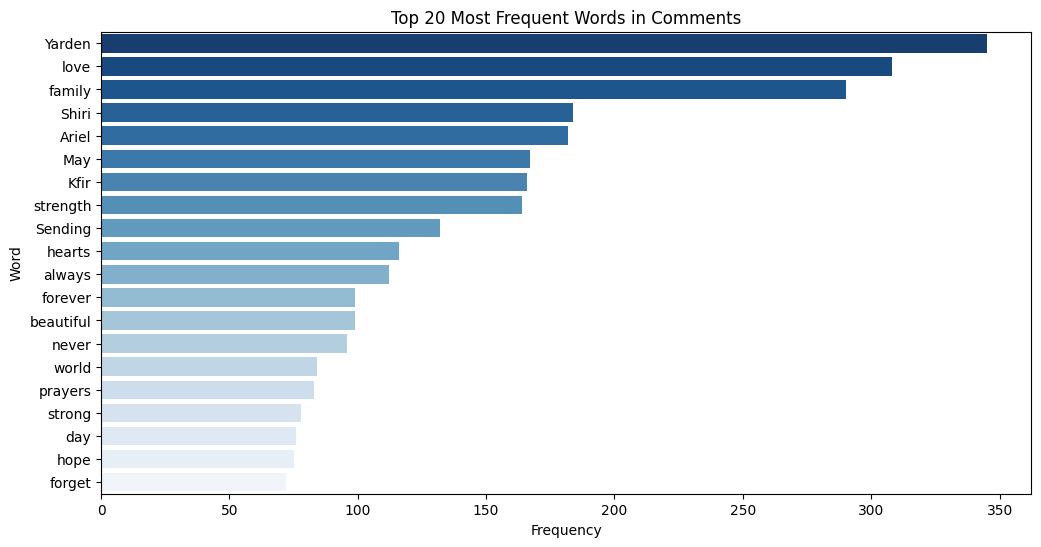

In [ ]:
# Count word frequencies
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)  # Get top 20 words

# Convert to DataFrame
freq_df = pd.DataFrame(common_words, columns=["word", "count"])

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="word", data=freq_df, palette="Blues_r")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Top 20 Most Frequent Words in Comments")
plt.show()

<ipython-input-95-23387ad45222>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




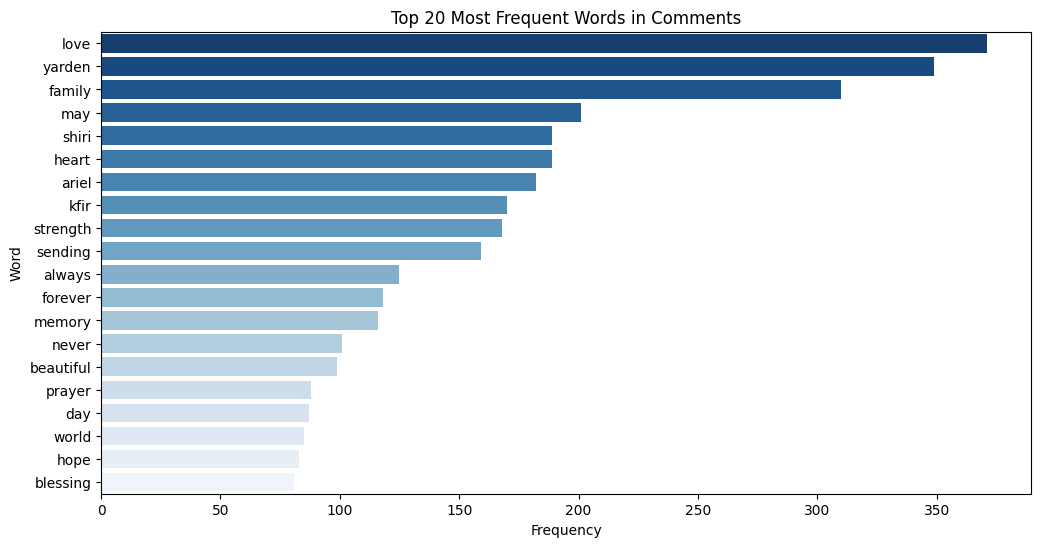

In [ ]:
word_counts_lemmatized = Counter(filtered_lemmatized_words)
common_words_lemmatized = word_counts_lemmatized.most_common(20)  # Get top 20 words

# Convert to DataFrame for plotting
freq_df = pd.DataFrame(common_words_lemmatized, columns=["word", "count"])

plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="word", data=freq_df, palette="Blues_r")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Top 20 Most Frequent Words in Comments")
plt.show()



In [ ]:
df_en_nltk_positive = df_en[df_en['Sentiment_nltk'].str.contains('Positive', case=False, na=False)]
df_en_nltk_negative = df_en[df_en['Sentiment_nltk'].str.contains('Negative', case=False, na=False)]
df_en_nltk_neutral = df_en[df_en['Sentiment_nltk'].str.contains('Neutral', case=False, na=False)]

df_en_distilbert_positive = df_en[df_en['Sentiment_distilbert'].str.contains('Positive', case=False, na=False)]
df_en_distilbert_negative = df_en[df_en['Sentiment_distilbert'].str.contains('Negative', case=False, na=False)]
df_en_distilbert_neutral = df_en[df_en['Sentiment_distilbert'].str.contains('Neutral', case=False, na=False)]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-103-4ad742f014f0>:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-103-4ad742f014f0>:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-103-4ad742f014f0>:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-103-4ad742f014f0>:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same eff

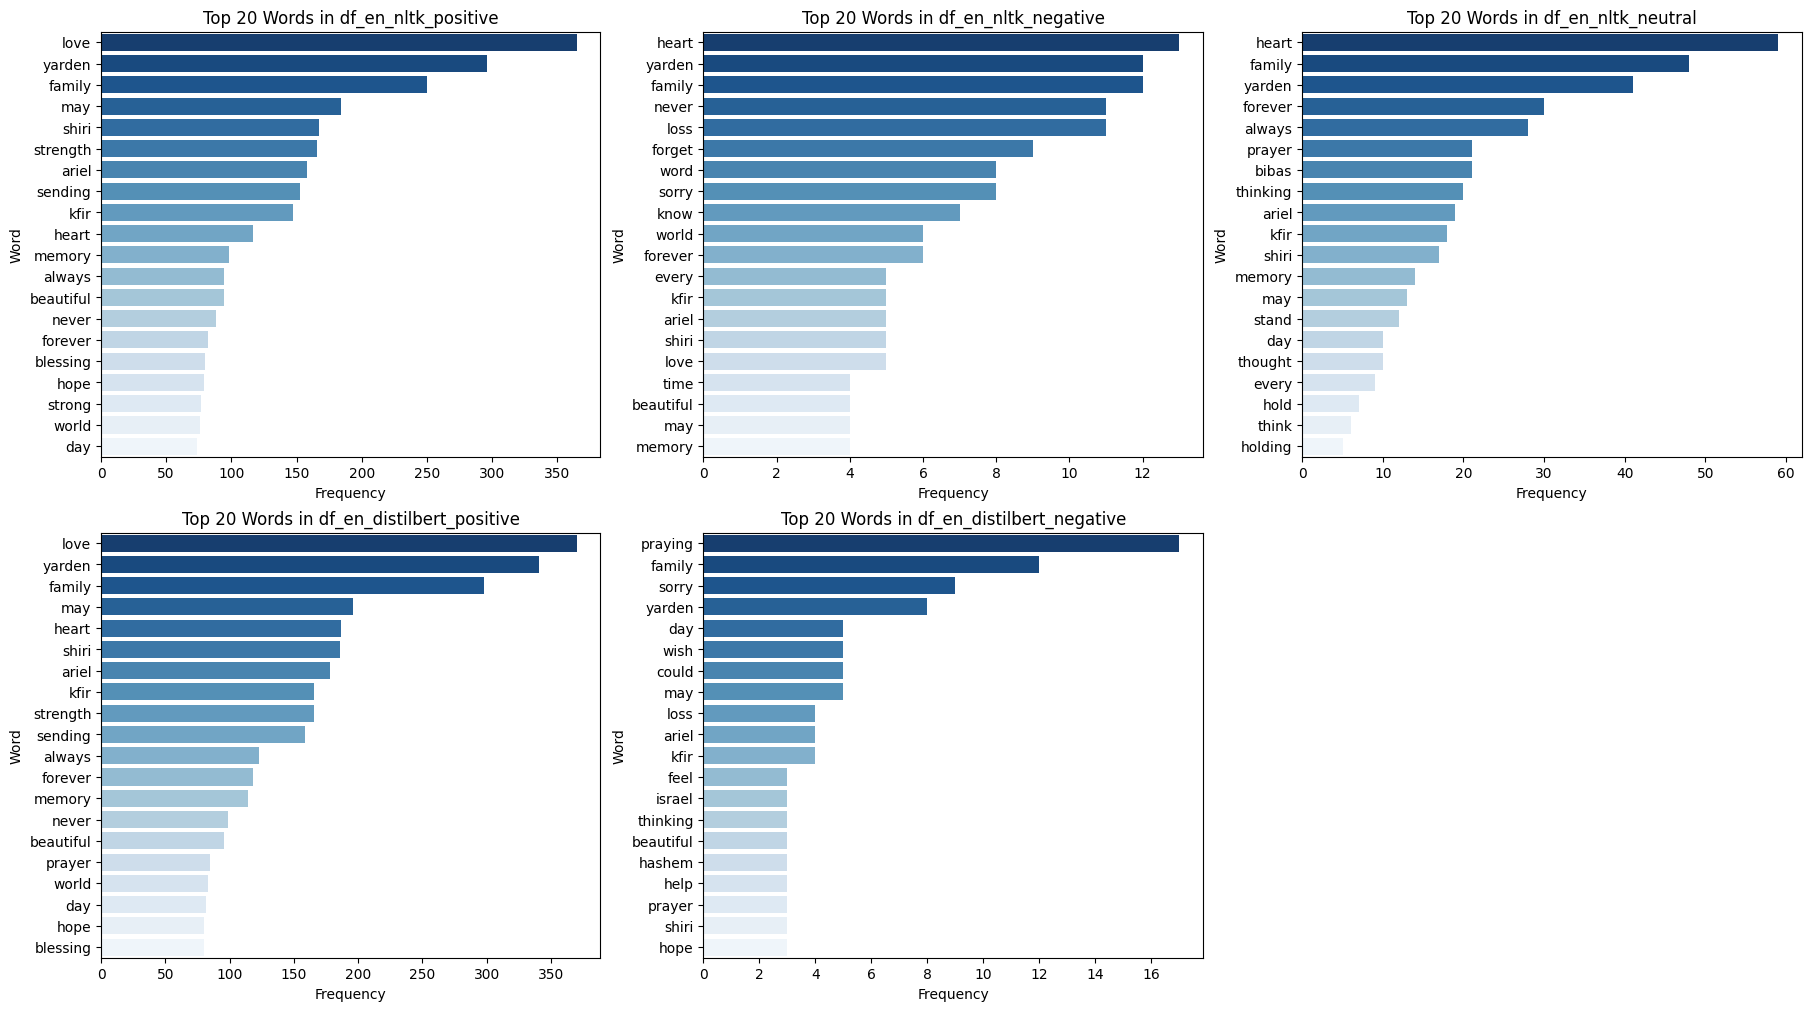

In [ ]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter

nltk.download('stopwords')
stop_words_set = set(stopwords.words("english"))

def preprocess_text(df, token_column, lemmatized_column):
    words_list = sum(df[token_column], [])
    lemmatized_tokens_list = sum(df[lemmatized_column], [])

    filtered_words = [w for w in words_list if w.isalnum() and w.lower() not in stop_words_set]
    filtered_lemmatized_words = [w for w in lemmatized_tokens_list if w.isalnum() and w.lower() not in stop_words_set]

    return filtered_lemmatized_words

def get_top_words(filtered_words, top_n=20):
    word_counts = Counter(filtered_words)
    return word_counts.most_common(top_n)

def plot_top_words(subplot_ax, common_words, title):
    freq_df = pd.DataFrame(common_words, columns=["word", "count"])

    sns.barplot(ax=subplot_ax, x="count", y="word", data=freq_df, palette="Blues_r")
    subplot_ax.set_xlabel("Frequency")
    subplot_ax.set_ylabel("Word")
    subplot_ax.set_title(title)

# List of DataFrames to process
dfs = {
    "df_en_nltk_positive": df_en_nltk_positive,
    "df_en_nltk_negative": df_en_nltk_negative,
    "df_en_nltk_neutral": df_en_nltk_neutral,
    "df_en_distilbert_positive": df_en_distilbert_positive,
    "df_en_distilbert_negative": df_en_distilbert_negative
}

# Set up subplots (2 rows: first row with 3 plots, second row with 2 plots)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
axes = axes.flatten()

# Process each DataFrame and plot in a different subplot
for i, (name, curr_df) in enumerate(dfs.items()):
    filtered_words = preprocess_text(curr_df, "tokens", "lemmatized_tokens")
    common_words = get_top_words(filtered_words)
    plot_top_words(axes[i], common_words, title=f"Top 20 Words in {name}")

# Hide any unused subplots
for j in range(len(dfs), len(axes)):
    fig.delaxes(axes[j])

plt.show()

##Word cloud
of negative | positive comments

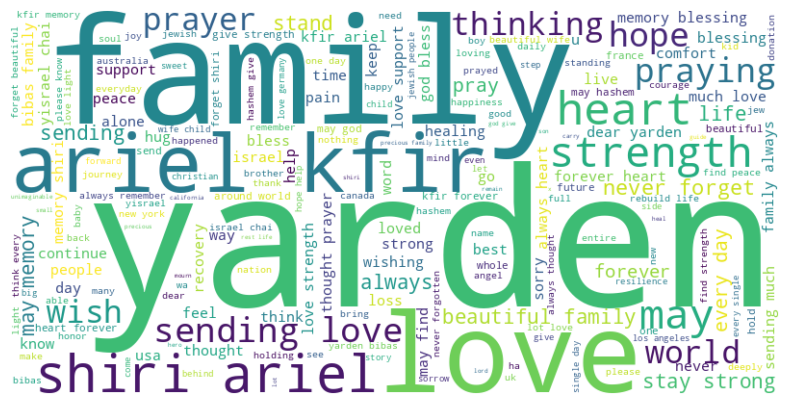

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(filtered_lemmatized_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

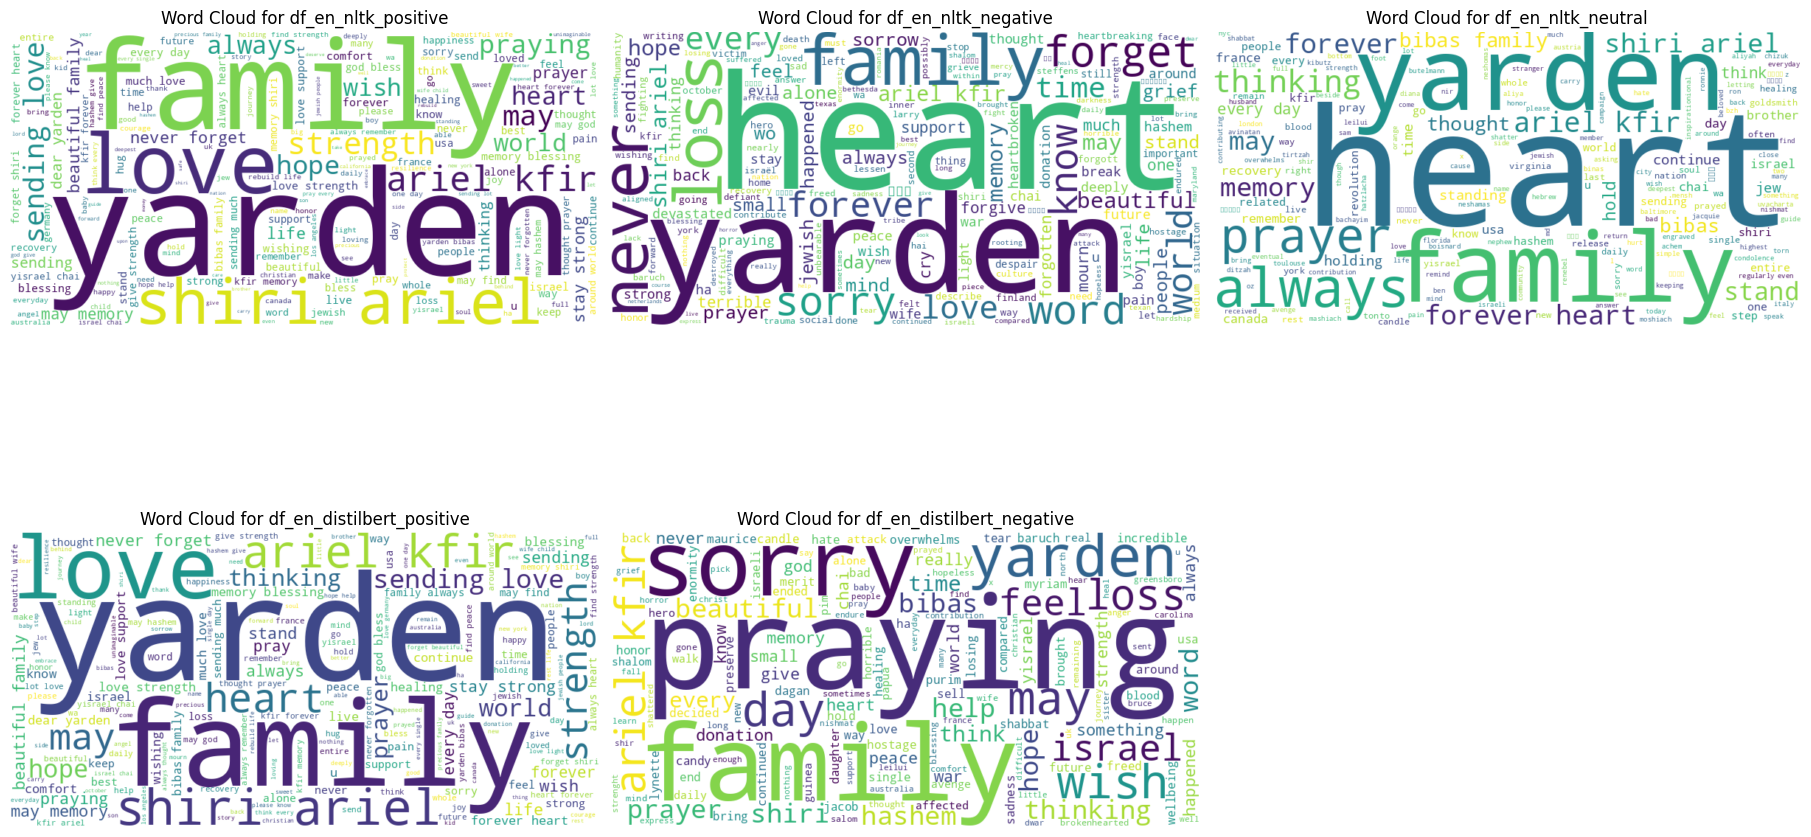

In [ ]:
def plot_wordcloud(subplot_ax, filtered_words, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(filtered_words))

    subplot_ax.imshow(wordcloud, interpolation="bilinear")
    subplot_ax.axis("off")
    subplot_ax.set_title(title)

# List of DataFrames to process
dfs = {
    "df_en_nltk_positive": df_en_nltk_positive,
    "df_en_nltk_negative": df_en_nltk_negative,
    "df_en_nltk_neutral": df_en_nltk_neutral,
    "df_en_distilbert_positive": df_en_distilbert_positive,
    "df_en_distilbert_negative": df_en_distilbert_negative
}

# Set up subplots (2 rows: first row with 3 plots, second row with 2 plots)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
axes = axes.flatten()

# Process each DataFrame and plot in a different subplot
for i, (name, df) in enumerate(dfs.items()):
    filtered_words = preprocess_text(df, "tokens", "lemmatized_tokens")
    plot_wordcloud(axes[i], filtered_words, title=f"Word Cloud for {name}")

# Hide any unused subplots
for j in range(len(dfs), len(axes)):
    fig.delaxes(axes[j])

plt.show()

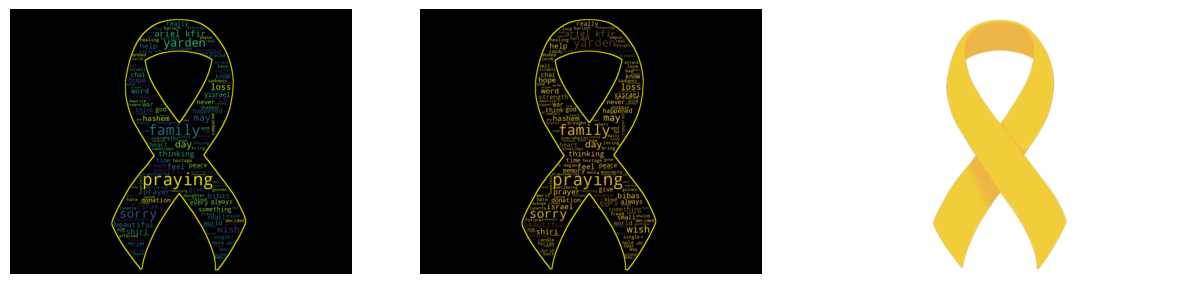

In [ ]:
from wordcloud import ImageColorGenerator
from PIL import Image


coloring = np.array(Image.open("/content/Yellow_Ribbon.png"))
mask = np.array(Image.open("/content/Yellow_Ribbon.png").convert("L"))
mask = np.where(mask < 128, 255, 0).astype(np.uint8)


wc = WordCloud(background_color="black", mask=mask, prefer_horizontal=0.99,
                      contour_width=4, contour_color='yellow').generate(" ".join(filtered_words))

# create coloring from image
image_colors = ImageColorGenerator(coloring)

# show
fig, axes = plt.subplots(1, 3, figsize=(15, 15))
axes[0].imshow(wc, interpolation="bilinear")
# recolor wordcloud and show
# we could also give color_func=image_colors directly in the constructor
axes[1].imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
axes[2].imshow(coloring, cmap=plt.cm.gray, interpolation="bilinear")
for ax in axes:
    ax.set_axis_off()
plt.show()

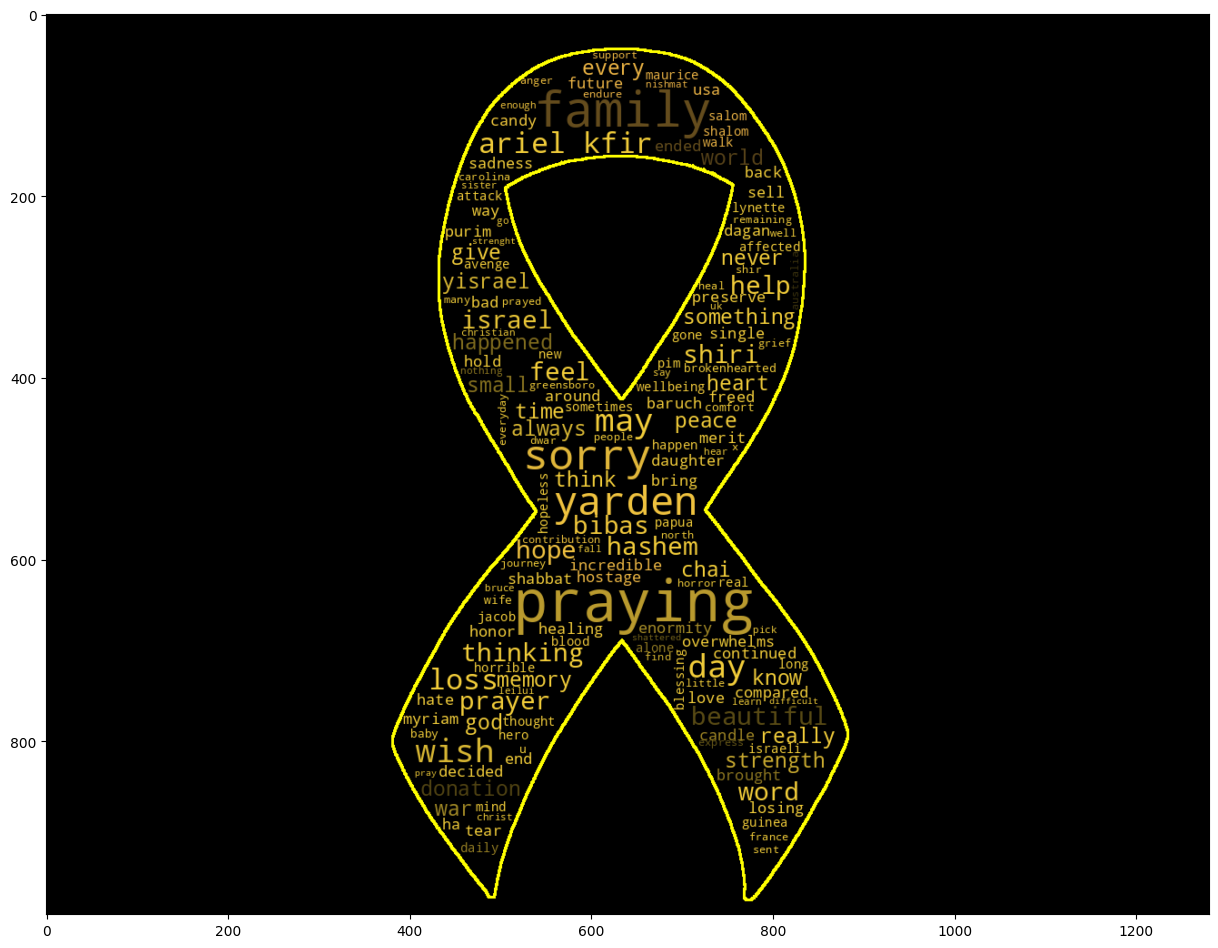

In [ ]:
from wordcloud import ImageColorGenerator


coloring = np.array(Image.open("/content/Yellow_Ribbon.png"))
mask = np.array(Image.open("/content/Yellow_Ribbon.png").convert("L"))
mask = np.where(mask < 128, 255, 0).astype(np.uint8)


wc = WordCloud(background_color="black", mask=mask, prefer_horizontal=0.99,
                      contour_width=4, contour_color='yellow').generate(" ".join(filtered_words))

# create coloring from image
image_colors = ImageColorGenerator(coloring)

# show
fig = plt.figure(figsize=(15, 15))

plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")

plt.show()